In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=MyApp>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_df =  spark.read.csv("/content/drive/MyDrive/Patient_nonresampled_traindata_1.csv", header=True, inferSchema=True)

In [8]:
test_df =  spark.read.csv("/content/drive/MyDrive/Patient_non_resampled_testdata_1.csv", header=True, inferSchema=True)

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col


In [10]:
# Define the input and output columns
input_cols = [c for c in train_df.columns if c != 'hospital_death']
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")


In [11]:
# Assemble the input data for training set
train_assembled = assembler.transform(train_df).select(col("hospital_death").alias("label"), col("features"))

# Assemble the input data for test set
test_assembled = assembler.transform(test_df).select(col("hospital_death").alias("label"), col("features"))

# Models

In [12]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col


Random Forest 

In [21]:
# Define the random forest model
rf = RandomForestClassifier()

# Define the parameter grid to search over
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Define the cross validator
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(),
                    numFolds=5)

# Train the model using the cross validator and the training data
rf_cvModel = cv.fit(train)

# Predict on the training data and evaluate accuracy
train_preds = rf_cvModel.transform(train)
train_accuracy = train_preds.filter(train_preds.label == train_preds.prediction).count() / float(train_preds.count())
print("Training Accuracy: {}".format(train_accuracy))

# Predict on the test data and evaluate accuracy
test_preds = rf_cvModel.transform(test)
test_accuracy = test_preds.filter(test_preds.label == test_preds.prediction).count() / float(test_preds.count())
print("Test Accuracy: {}".format(test_accuracy))

Training Accuracy: 0.936161823271953
Test Accuracy: 0.9256282191353208


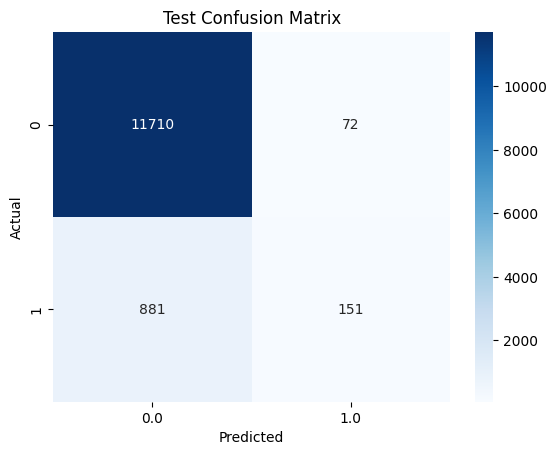

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get the predictions and labels as a Pandas DataFrame
test_preds_df = test_preds.select(['prediction', 'label']).toPandas()

# Create a confusion matrix using Pandas
confusion_matrix = pd.crosstab(test_preds_df['label'], test_preds_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix using Seaborn
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title("Test Confusion Matrix")
plt.show()


In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator with 'f1' metric
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Get the F1 score for the test data
test_f1 = evaluator.evaluate(test_preds)
print("Test F1 Score: {}".format(test_f1))


Test F1 Score: 0.9028916855912631


Logistic regression without cv

In [14]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Train the model using the training data
lrModel_withoutCV = lr.fit(train_assembled)

# Predict on the training data and evaluate accuracy
train_preds_lr = lrModel_withoutCV.transform(train_assembled)
train_accuracy_lr = train_preds_lr.filter(train_preds_lr.label == train_preds_lr.prediction).count() / float(train_preds_lr.count())
print("Training Accuracy: {}".format(train_accuracy_lr))

# Predict on the test data and evaluate accuracy
test_preds_lr = lrModel_withoutCV.transform(test_assembled)
test_accuracy_lr = test_preds_lr.filter(test_preds_lr.label == test_preds_lr.prediction).count() / float(test_preds_lr.count())
print("Test Accuracy: {}".format(test_accuracy_lr))


Training Accuracy: 0.9222484541877459
Test Accuracy: 0.9195215361208751


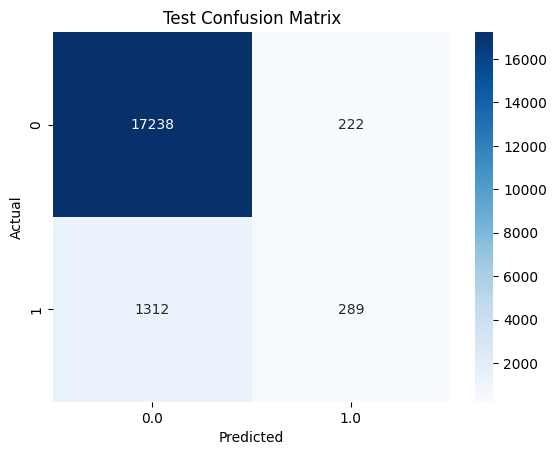

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get the predictions and labels as a Pandas DataFrame
test_preds_df_lr = test_preds_lr.select(['prediction', 'label']).toPandas()

# Create a confusion matrix using Pandas
confusion_matrix = pd.crosstab(test_preds_df_lr['label'], test_preds_df_lr['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix using Seaborn
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title("Test Confusion Matrix")
plt.show()


In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator with 'f1' metric
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Get the F1 score for the test data
test_f1_lr = evaluator.evaluate(test_preds_lr)
print("Test F1 Score: {}".format(test_f1_lr))

Test F1 Score: 0.8999721456701857


Neural Network

In [15]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define the MLP model
layers = [len(input_cols), 64, 64, 2] # define the number of neurons in each layer
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128,seed=1234)

# Train the model using the training data
mlp_Model = mlp.fit(train_assembled)

# Predict on the training data and evaluate accuracy
train_preds_mlp = mlp_Model.transform(train_assembled)
train_accuracy_mlp = train_preds_mlp.filter(train_preds_mlp.label == train_preds_mlp.prediction).count() / float(train_preds_mlp.count())
print("Training Accuracy: {}".format(train_accuracy_mlp))

# Predict on the test data and evaluate accuracy
test_preds_mlp = mlp_Model.transform(test_assembled)
test_accuracy_mlp = test_preds_mlp.filter(test_preds_mlp.label == test_preds_mlp.prediction).count() / float(test_preds_mlp.count())
print("Test Accuracy: {}".format(test_accuracy_mlp))


Training Accuracy: 0.9193029792017987
Test Accuracy: 0.9181050312155711


Exception ignored in: <function JavaWrapper.__del__ at 0x7f7ab3061160>
Traceback (most recent call last):
  File "/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'MultilayerPerceptronClassifier' object has no attribute '_java_obj'


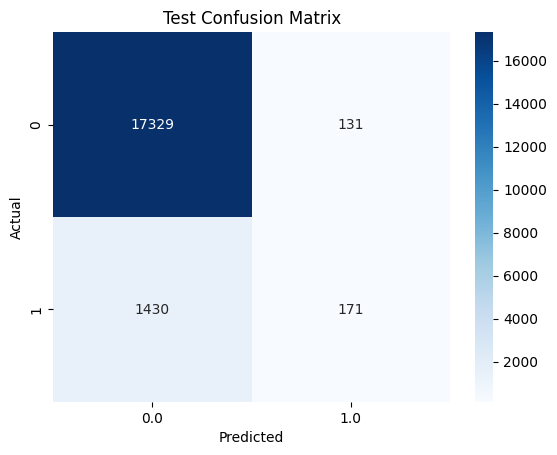

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get the predictions and labels as a Pandas DataFrame
test_preds_df = test_preds_mlp.select(['prediction', 'label']).toPandas()

# Create a confusion matrix using Pandas
confusion_matrix = pd.crosstab(test_preds_df['label'], test_preds_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix using Seaborn
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title("Test Confusion Matrix")
plt.show()


In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator with 'f1' metric
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Get the F1 score for the test data
test_f1_mlp = evaluator.evaluate(test_preds_mlp)
print("Test F1 Score: {}".format(test_f1_mlp))


Test F1 Score: 0.891622603677237


RF Without CV

In [20]:


# Define the random forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")


# Train the model using the cross validator and the training data
rf_Model = rf.fit(train_assembled)

# Predict on the training data and evaluate accuracy
train_preds = rf_Model.transform(train_assembled)
train_accuracy = train_preds.filter(train_preds.label == train_preds.prediction).count() / float(train_preds.count())
print("Training Accuracy: {}".format(train_accuracy))

# Predict on the test data and evaluate accuracy
test_preds = rf_Model.transform(test_assembled)
test_accuracy = test_preds.filter(test_preds.label == test_preds.prediction).count() / float(test_preds.count())
print("Test Accuracy: {}".format(test_accuracy))

Training Accuracy: 0.9201573917931423
Test Accuracy: 0.9201510938565658


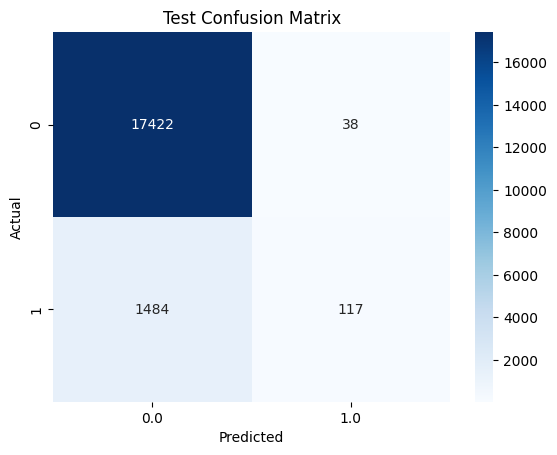

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get the predictions and labels as a Pandas DataFrame
test_preds_df = test_preds.select(['prediction', 'label']).toPandas()

# Create a confusion matrix using Pandas
confusion_matrix = pd.crosstab(test_preds_df['label'], test_preds_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix using Seaborn
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title("Test Confusion Matrix")
plt.show()


In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator with 'f1' metric
evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Get the F1 score for the test data
test_f1 = evaluator.evaluate(test_preds)
print("Test F1 Score: {}".format(test_f1))


Test F1 Score: 0.8888623000187721
